# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per square mile (by Census Tract) 

### QUEENS

In [109]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [110]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [111]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [112]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [113]:
# look at only Queens
QN_trees_sqmile = trees_cts.query("county == 'Queens'")

[Text(0.5, 1.0, 'Queens')]

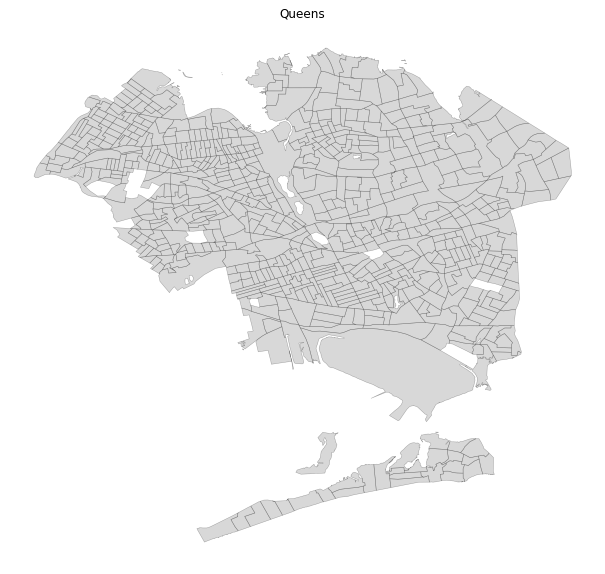

In [114]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
QN_trees_sqmile.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Queens')

In [115]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
QN_trees_sqmile = QN_trees_sqmile.dropna(subset = ['trees_per_sqmile'])

In [116]:
# drop trees per capita with 0
QN_trees_sqmile = QN_trees_sqmile.query("trees_per_sqmile > 0")

In [125]:
w_QN = weights.Queen.from_dataframe(QN_trees_sqmile)

In [127]:
w_QN = weights.KNN.from_dataframe(QN_trees_sqmile, k=1)

In [128]:
w_QN = weights.attach_islands(w_QN, w_knn_QN)

There are no disconnected observations (no islands)!


In [129]:
# row standardize weights
w_QN.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per square mile*

In [130]:
# on trees per capita
local_moran_QN = esda.moran.Moran_Local(QN_trees_sqmile['trees_per_sqmile'], w_QN)

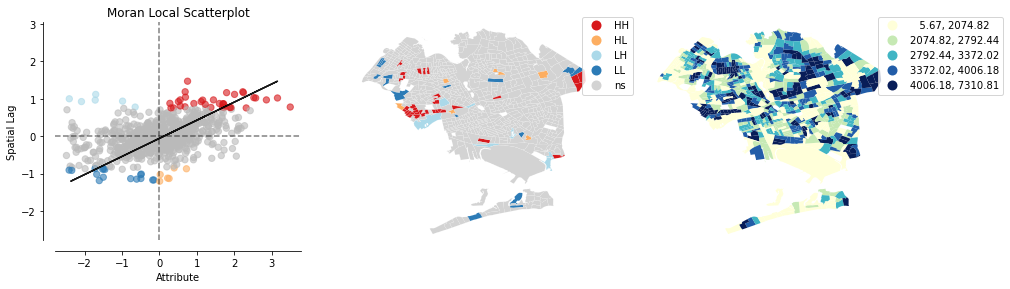

In [131]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_QN, QN_trees_sqmile,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Queens/Queens_Trees-per-SquareMile_moran.pdf")

In [132]:
# get clusters and outliers - adding columns to the DF

QN_trees_sqmile['local_moran_Is'] = local_moran_QN.Is
QN_trees_sqmile['local_moran_p_value'] = local_moran_QN.p_sim
QN_trees_sqmile['local_moran_quadrant'] = local_moran_QN.q

In [133]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_QN = QN_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_QN = QN_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_QN = QN_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_QN = QN_trees_sqmile.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

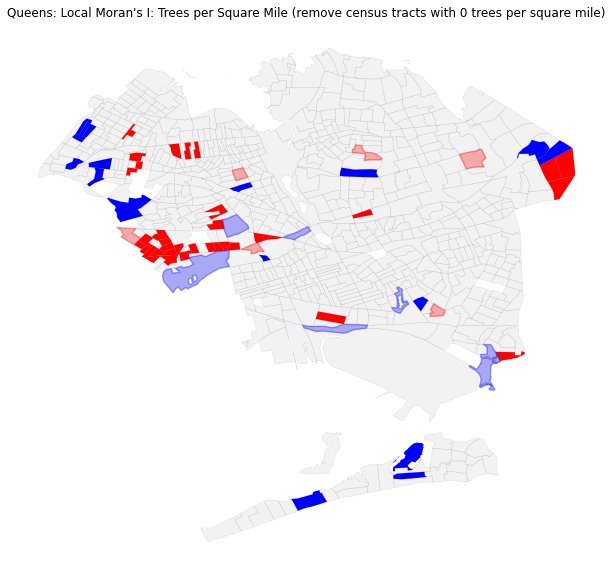

In [134]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
QN_trees_sqmile.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
QN_trees_sqmile.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_QN.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_QN.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_QN.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_QN.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Queens: Local Moran's I: Trees per Square Mile (remove census tracts with 0 trees per square mile)")

plt.savefig("maps/Queens/Queens_Trees-per-SquareMile.pdf")

### *investigate the numbers*

In [168]:
# look at smallest values
QN_trees_sqmile['trees_per_sqmile'].nsmallest(n=10)

900       5.669894
950      23.056478
1961     92.585140
945      98.551763
529     125.771217
1676    147.242195
1904    167.968454
2068    178.937279
1720    189.036457
903     190.323449
Name: trees_per_sqmile, dtype: float64

In [170]:
# look at largest values
QN_trees_sqmile['trees_per_sqmile'].nlargest(n=10)

616     7310.811922
506     6894.213369
2200    6532.286386
615     6182.042145
569     6122.073859
1708    6004.187450
229     5873.469795
1892    5818.987042
2232    5782.219126
2058    5761.700399
Name: trees_per_sqmile, dtype: float64

In [137]:
# lowest 1% of data
print(QN_trees_sqmile['trees_per_sqmile'].quantile(q = 0.01))

179.54322990236653


In [138]:
# lowest 5% of data
print(QN_trees_sqmile['trees_per_sqmile'].quantile(q = 0.05))

909.8232718555788


In [139]:
# lowest 10% of data
print(QN_trees_sqmile['trees_per_sqmile'].quantile(q = 0.10))

1511.9390059806988


In [140]:
# lowest 20% of data
print(QN_trees_sqmile['trees_per_sqmile'].quantile(q = 0.20))

2074.820633248849


In [141]:
# highest 1% of data
print(QN_trees_sqmile['trees_per_sqmile'].quantile(q = 0.99))

5816.780966630971


In [142]:
# highest 5% of data
print(QN_trees_sqmile['trees_per_sqmile'].quantile(q = 0.95))

5111.045584064754


In [143]:
# highest 10% of data
print(QN_trees_sqmile['trees_per_sqmile'].quantile(q = 0.90))

4604.400998931325


In [144]:
# highest 20% of data
print(QN_trees_sqmile['trees_per_sqmile'].quantile(q = 0.80))

4006.180006652251


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 200 and more than 6,000  trees per square mile*

In [149]:
# limit the range
QN_trees_sqmile_limit = QN_trees_sqmile.query("trees_per_sqmile > 200 & trees_per_sqmile < 6000")

In [157]:
w_QN2 = weights.Queen.from_dataframe(QN_trees_sqmile_limit)

In [158]:
w_QN2 = weights.KNN.from_dataframe(QN_trees_sqmile_limit, k=1)

In [159]:
w_QN2 = weights.attach_islands(w_QN2, w_knn_QN2)

There are no disconnected observations (no islands)!


In [160]:
# row standardize weights
w_QN2.transform = 'R'

In [161]:
# on trees per capita
local_moran_QN2 = esda.moran.Moran_Local(QN_trees_sqmile_limit['trees_per_sqmile'], w_QN2)

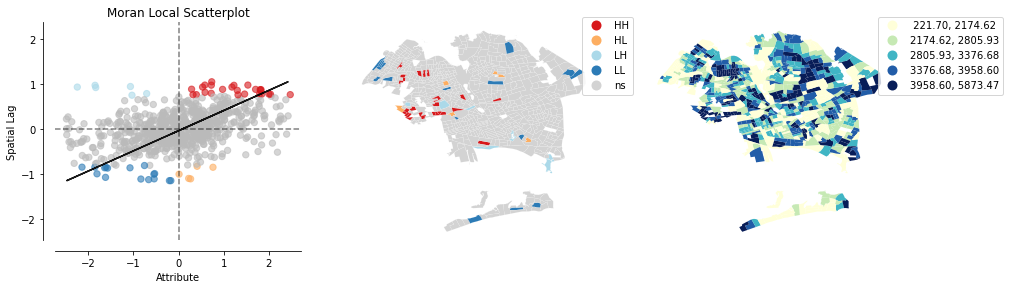

In [162]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_QN2, QN_trees_sqmile_limit,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Queens/Queens_Trees-per-SquareMile_limited_moran.pdf")

In [164]:
# get clusters and outliers
QN_trees_sqmile_limit['local_moran_Is'] = local_moran_QN2.Is
QN_trees_sqmile_limit['local_moran_p_value'] = local_moran_QN2.p_sim
QN_trees_sqmile_limit['local_moran_quadrant'] = local_moran_QN2.q

In [165]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_QN2 = QN_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_QN2 = QN_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_QN2 = QN_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_QN2 = QN_trees_sqmile_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

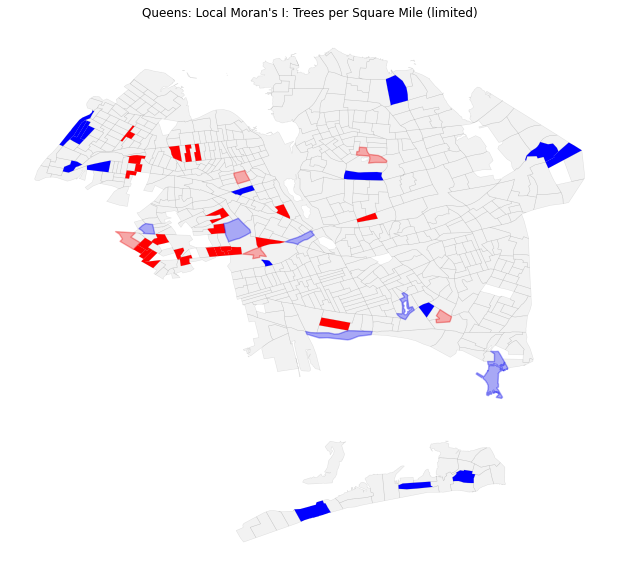

In [166]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
QN_trees_sqmile_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
QN_trees_sqmile_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_QN2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_QN2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_QN2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_QN2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Queens: Local Moran's I: Trees per Square Mile (limited)")

plt.savefig("maps/Queens/Queens_Trees-per-SquareMile_limited.pdf")

## Spatial Autocorrelation - Local Moran's I - more limited
### *removed all census tracts with less than 500 and more than 5,000  trees per square mile*

In [176]:
# limit the range
QN_trees_sqmile_limit_more = QN_trees_sqmile.query("trees_per_sqmile > 500 & trees_per_sqmile < 5000")

In [178]:
# create queen contiguity weights
w_QN3 = weights.Queen.from_dataframe(QN_trees_sqmile_limit_more)

In [181]:
w_QN3 = weights.Queen.from_dataframe(QN_trees_sqmile_limit_more)

In [183]:
w_QN3 = weights.KNN.from_dataframe(QN_trees_sqmile_limit_more, k=1)

In [189]:
# row standardize weights
w_QN3.transform = 'R'

In [192]:
# on trees per capita
local_moran_QN3 = esda.moran.Moran_Local(QN_trees_sqmile_limit_more['trees_per_sqmile'], w_QN3)

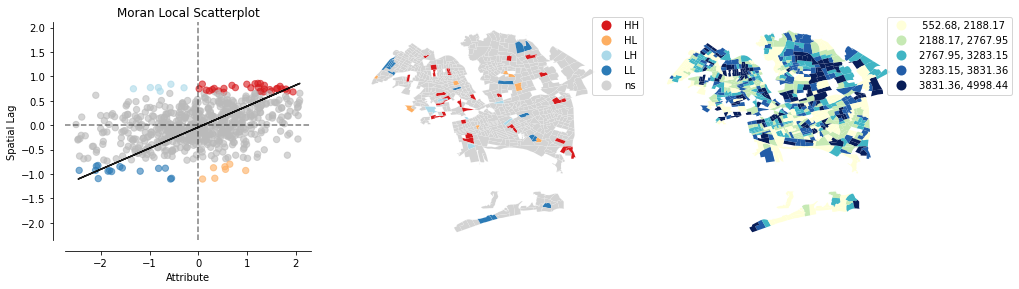

In [195]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_QN3, QN_trees_sqmile_limit_more,'trees_per_sqmile', p = 0.05 );

plt.savefig("maps/Queens/Queens_Trees-per-SquareMile_more-limited_moran.pdf")

In [198]:
# get clusters and outliers
QN_trees_sqmile_limit_more['local_moran_Is'] = local_moran_QN3.Is
QN_trees_sqmile_limit_more['local_moran_p_value'] = local_moran_QN3.p_sim
QN_trees_sqmile_limit_more['local_moran_quadrant'] = local_moran_QN3.q

In [200]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_QN3 = QN_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_QN3 = QN_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_QN3 = QN_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_QN3 = QN_trees_sqmile_limit_more.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

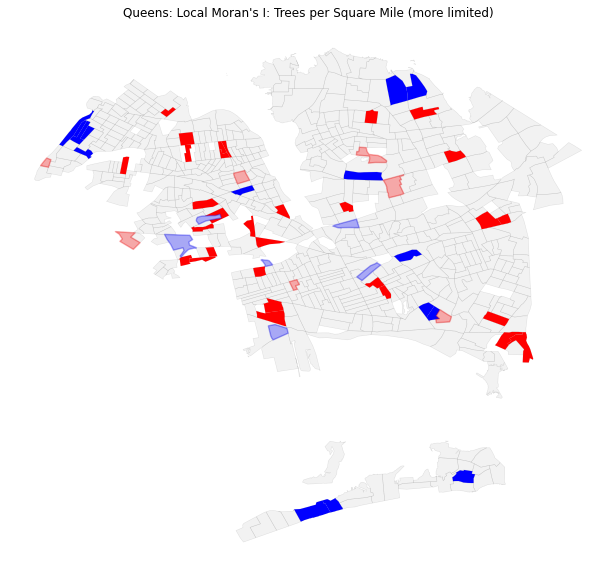

In [201]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
QN_trees_sqmile_limit_more.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
QN_trees_sqmile_limit_more.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_QN3.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_QN3.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_QN3.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_QN3.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Queens: Local Moran's I: Trees per Square Mile (more limited)")

plt.savefig("maps/Queens/Queens_Trees-per-SquareMile_more-limited.pdf")